"""

This notebook intends to illustrate how autoencoder is used to detect anomaly time series sequence.
It does not output any data and no output is used in the final prediction.

"""

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from matplotlib import pyplot as plt

### Define Data Path and Load period

In [2]:
path = '../data-sets/KDD-Cup/data/'
period_path = '../data-sets/KDD-Cup/period/period.csv'
files_name = [i for i in os.listdir(path) if 'Anomaly' in i] #remove irrelevant files
files_name.sort(key = lambda x : x.split('_')[0]) #sort by id

In [3]:
period = pd.read_csv(period_path) #load period file calculated by fourier transform
period.head()

,File_name,Period
0,001_UCR_Anomaly_35000.txt,210
1,002_UCR_Anomaly_35000.txt,208
2,003_UCR_Anomaly_35000.txt,209
3,004_UCR_Anomaly_2500.txt,80
4,005_UCR_Anomaly_4000.txt,24


### Load data

In [4]:
name = files_name[100]
print("The example data used is :",name)
split_index  = int(name.split('.')[0].split('_')[3]) #get split index
data = pd.read_csv(path+name,header=None)
train,test = data[0:split_index],data[split_index::] #split
test = test.reset_index().drop('index',axis=1)

The example data used is : 101_UCR_Anomaly_6000.txt


### Normalize

In [5]:
training_mean = train.mean()  #record mean
training_std = train.std() #record std
normalized_train = (train - training_mean) / training_std

### Create Sequence for training data & validation data

In [6]:
def to_even(TIME_STEPS):
    """
    To ensure the period is even and it is multipleir of 4
    """
    if TIME_STEPS % 2 != 0:
        TIME_STEPS -= 1
    if TIME_STEPS % 4 != 0:
        TIME_STEPS -= 2 
    return TIME_STEPS
TIME_STEPS = int(period[period['File_name'] == name]['Period'])
TIME_STEPS = to_even(TIME_STEPS)

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

normalized_train = create_sequences(normalized_train)
x_train,x_valid = normalized_train[0:int(0.8*len(train)),:,:],normalized_train[int(0.8*len(train))::,:,:]
print("Training input shape: ", x_train.shape,"Validation input shape: ", x_valid.shape)

Training input shape:  (4800, 32, 1) Validation input shape:  (1169, 32, 1)


### Define Model & Optimizer & Callback

In [7]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=5, padding="same", strides=2, activation="elu"
        ),      
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=5, padding="same", strides=2, activation="elu"
        ),  
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=5, padding="same", strides=2, activation="elu"
        ),
        layers.Conv1DTranspose(
            filters=32, kernel_size=5, padding="same", strides=2, activation="elu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            192       
_________________________________________________________________
dropout (Dropout)            (None, 16, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 16)             2576      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 16)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 16, 16)            1296      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 32, 32)            2592      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 32, 1)             2

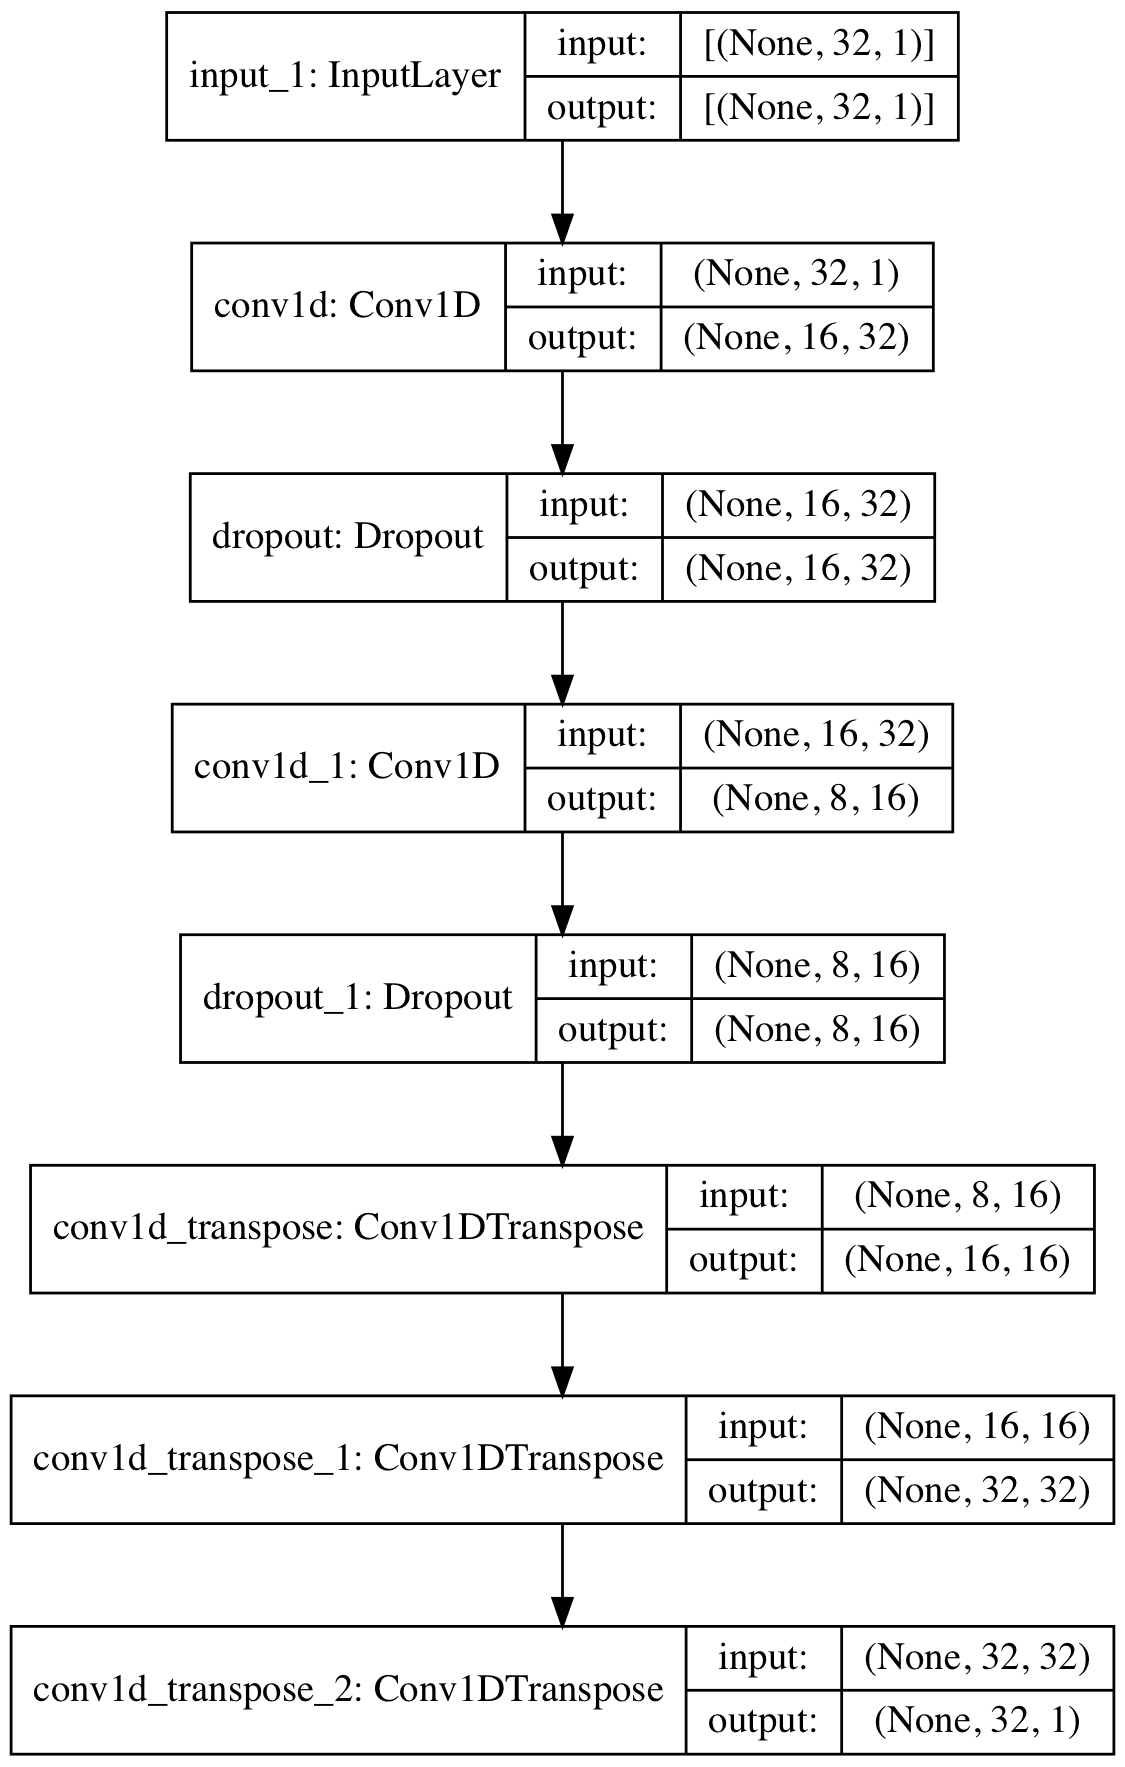

In [8]:
dot_img_file = 'model.png'
keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True,dpi=200)

### Training

In [9]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10
    end_lr = 0.00001
    lrate = initial_lrate * np.power(drop,  
        np.floor((1+epoch)/epochs_drop))
    if lrate > end_lr:
        return lrate
    else:
        return end_lr
    

epochs = 100
batch_size = 32
lr_scheduler = LearningRateScheduler(step_decay)
optimizer = keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer, loss="mse")

history = model.fit(
    x_train,
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_valid,x_valid),
    callbacks=[
        lr_scheduler
    ],
    verbose=1
)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-28 23:20:07.101716: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-28 23:20:07.101867: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/150 [==========================>...] - ETA: 0s - loss: 0.3576WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x16783d550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
150/150 [==============================] - 1s 5ms/step - loss: 0.3432 - val_loss: 0.0653
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0861 - val_loss: 0.0510
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0774 - val_loss: 0.0459
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0720 - val_loss: 0.0458
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0715 - val_loss: 0.0527
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0700 - val_loss: 0.0702
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0694 - val_l

### Plot training history

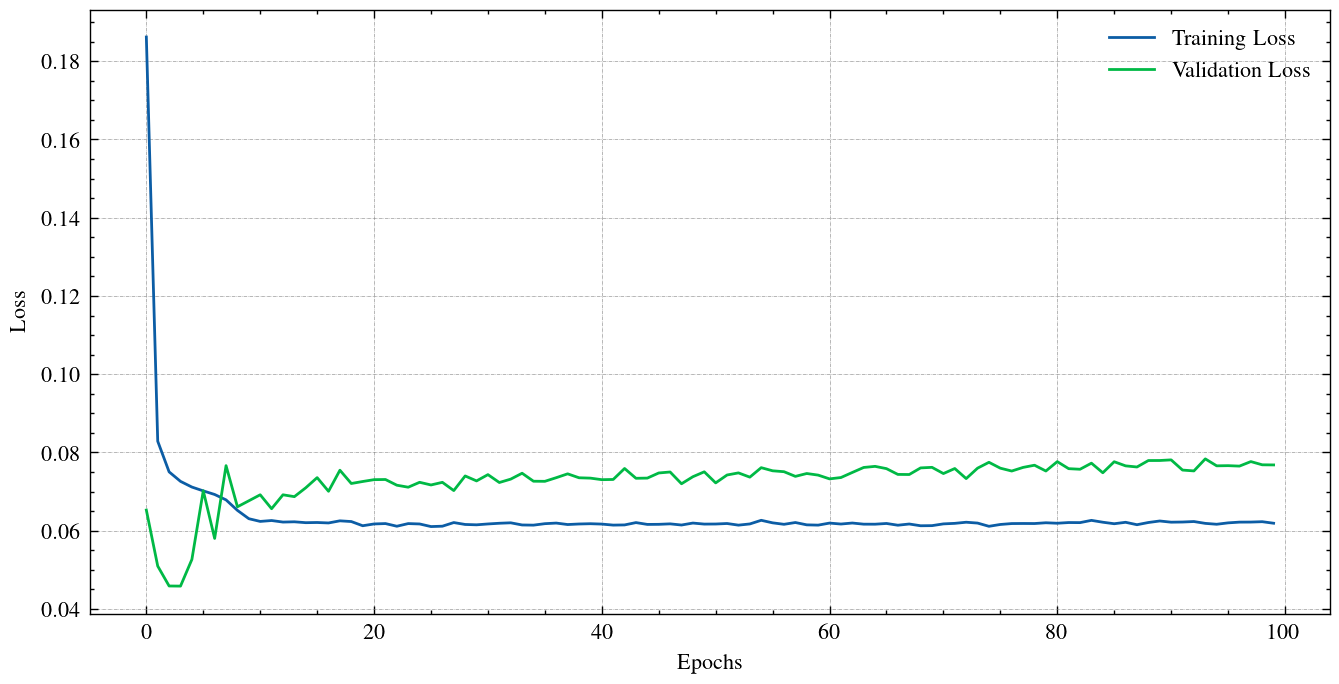

In [10]:
plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[8,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize the construction error on training set and define error threshold

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


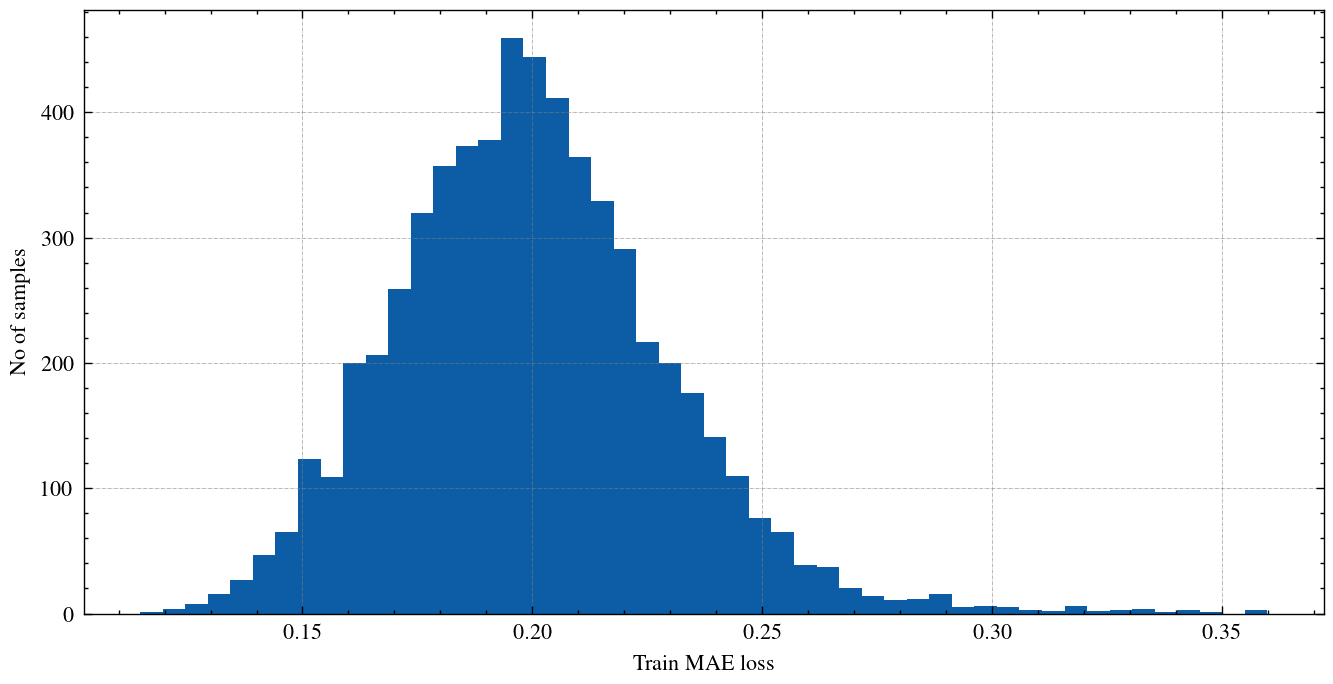

Reconstruction error threshold:  0.3598568685706194


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(normalized_train)
train_mae_loss = np.mean(np.abs(x_train_pred - normalized_train), axis=1)

plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[8,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Perform prediction on test data and plot the MAE distribution

Test input shape:  (24035, 32, 1)


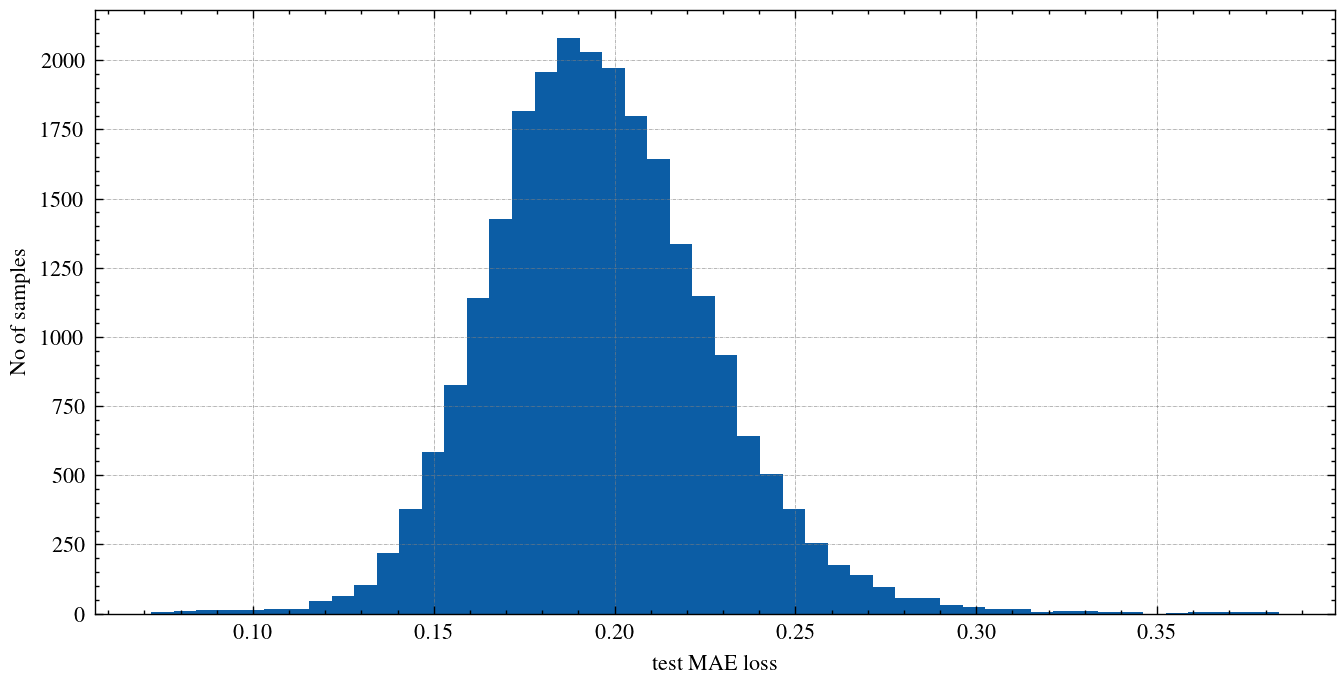

Number of anomaly samples:  19
Indices of anomaly samples:  (array([11419, 11422, 11423, 11427, 11549, 11550, 11611, 11612, 11613,
       11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622,
       23912]),)


In [12]:
normalized_test = (test- training_mean) / training_std

# Create sequences from test values.
x_test = create_sequences(normalized_test)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[8,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

## THE FOLLOWING PART IS NOT RELLEVANT, BUT WE HOPE TO KEEP THIS
## Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

### Plot the accumulative residuals on test data

Text(0, 0.5, 'Accumulative Residuals')

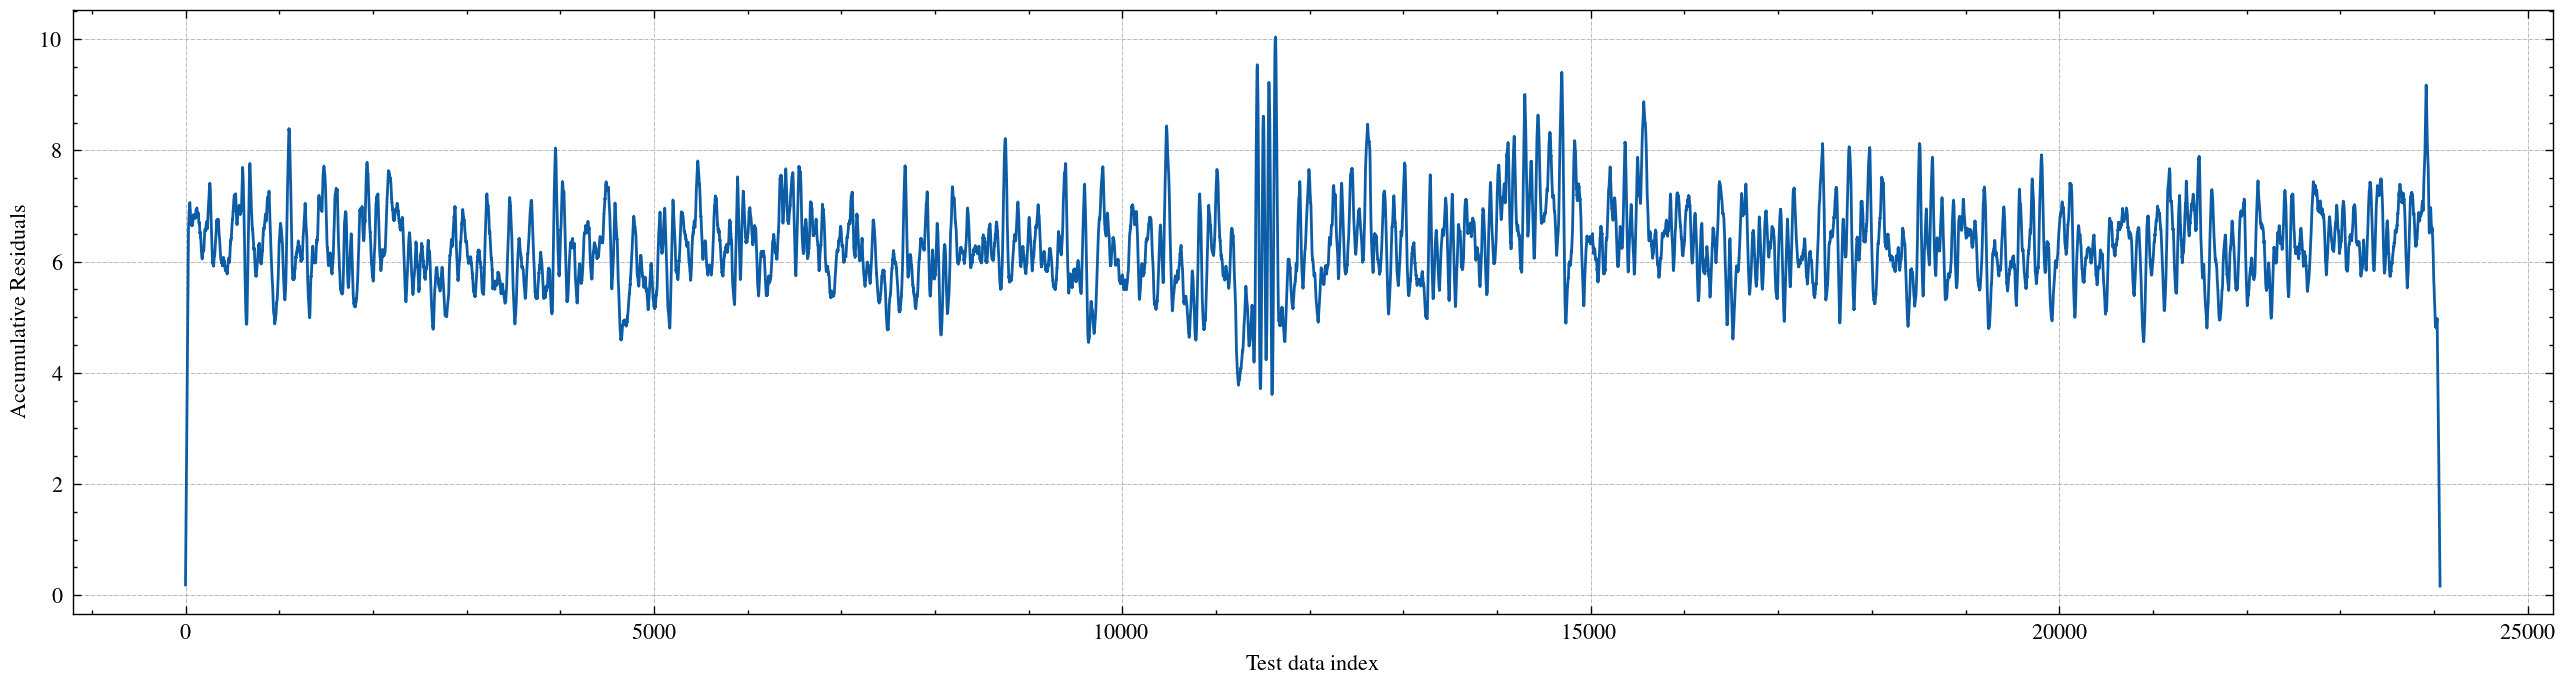

In [13]:
acc_residuals = [0]*len(normalized_test)

start_index = 0
for loss in test_mae_loss:
    for t in range(TIME_STEPS):
        acc_residuals[start_index+t] += loss
    start_index += 1

plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[16,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
plt.plot(acc_residuals)
plt.xlabel('Test data index')
plt.ylabel('Accumulative Residuals')

### Get the midpoint of suspicious sequence using maximum residuals

In [14]:
max_index = acc_residuals.index(max(acc_residuals[TIME_STEPS:-1-TIME_STEPS]))
print("The index with maximum residuals is : ", max_index)

The index with maximum residuals is :  11635


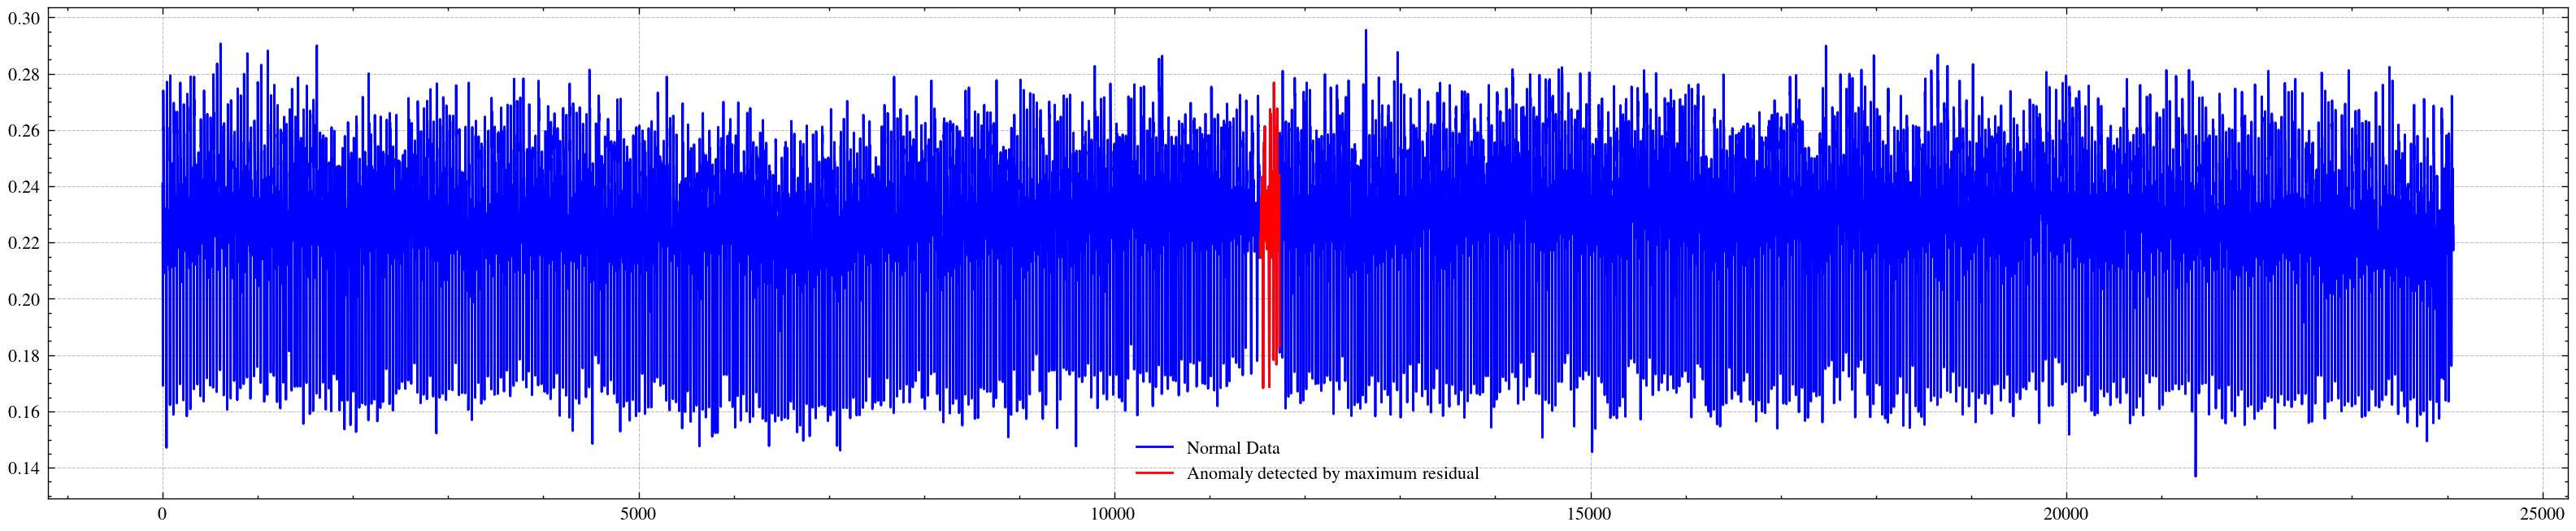

In [15]:
plt.style.use(['science','ieee','std-colors'])
fig = plt.figure(figsize=[20,4],dpi=200)
fig.patch.set_facecolor('#FFFFFF')
plt.grid(color='grey', linestyle='-.', linewidth=0.2)
n = len(test)
plt.plot(test,color='blue',label='Normal Data')
plt.plot(range(max_index-100,min(max_index+100,n)),test[max_index-100:min(max_index+100,n)],color='red',label='Anomaly detected by maximum residual')
plt.legend()